# Data Engineers' Challenge 3: The UpLift Challenge

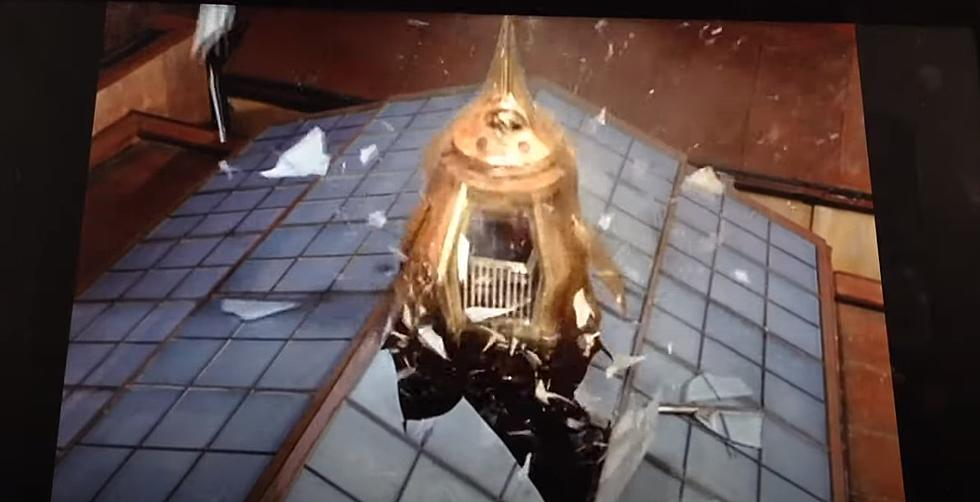

## Import packages

In [206]:
import time
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tkinter import Tk, Canvas, TclError
import numpy as np
from datetime import datetime, timedelta, time
from create_entries import create_entries_df
from charts import plot_mean_floor_by_half_hour, wait_times_histogram, award_points
from elevator_simulation import single_simulation

## Submissions

### Jono

In [207]:
def efficient_time_of_day(timestamp, elevator_population, floor_population, floors, elevator_floor, t_floor):
    """If the elevator has passengers, prioritize their destinations first"""
    if elevator_population:
        # Find the nearest destination for current passengers
        closest_floor = min(elevator_population, key=lambda x: abs(x - elevator_floor))

    # If there are no passengers, consider picking up people from other floors
    elif any(floor_population):  # Check if there's anyone waiting on any floor
        # Sort floors by proximity to the current elevator position
        closest_floor = min((floor for floor in range(1, floors + 1) if floor_population[floor] > 0), 
                            key=lambda x: abs(x - elevator_floor))
    else:
        if timestamp.hour < 10 or (13 <= timestamp.hour < 14):
            closest_floor = 2  # No one in the elevator and no one waiting
        else:
            closest_floor = elevator_floor

    return closest_floor

def baseline_algorithm(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):
    """Simple logic: If the lift is at the bottom floor, head upwards. If the lift is at the 
    top floor, head back down. If in the middle, use the previous direction"""
    
    return floors if elevator_floor == 1 else 1 if elevator_floor == floors else t_floor

### Harmonic Oscillator


In [208]:
def harmonic_oscillator(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):

    timestamp = np.random.random(1)*int(timestamp.timestamp()) / 100000
    
    A = (floors-1)/2
    zeta = max(min(1 - sum(floor_population)/floors, 1), 0) * .01
    w0 = elevator_floor/floors * .01
    phi = 0
    
    t_plot = np.linspace(0, timestamp+10, 1000)
    z_plot = A*np.exp(-zeta*w0*t_plot)*np.sin(np.sqrt(1-zeta**2)*w0*t_plot+phi) + A + 1

    t = timestamp
    z = A*np.exp(-zeta*w0*t)*np.sin(np.sqrt(1-zeta**2)*w0*t+phi) + A + 1

    # plt.plot(t_plot, z_plot)
    # plt.scatter(t, z)
    # plt.show()

    # print(zeta)
    # print(w0)
    # print(elev_pop)
    # print(floor_population)
    # print(elevator_floor)
    # print(z)
    # print('---')

    return z


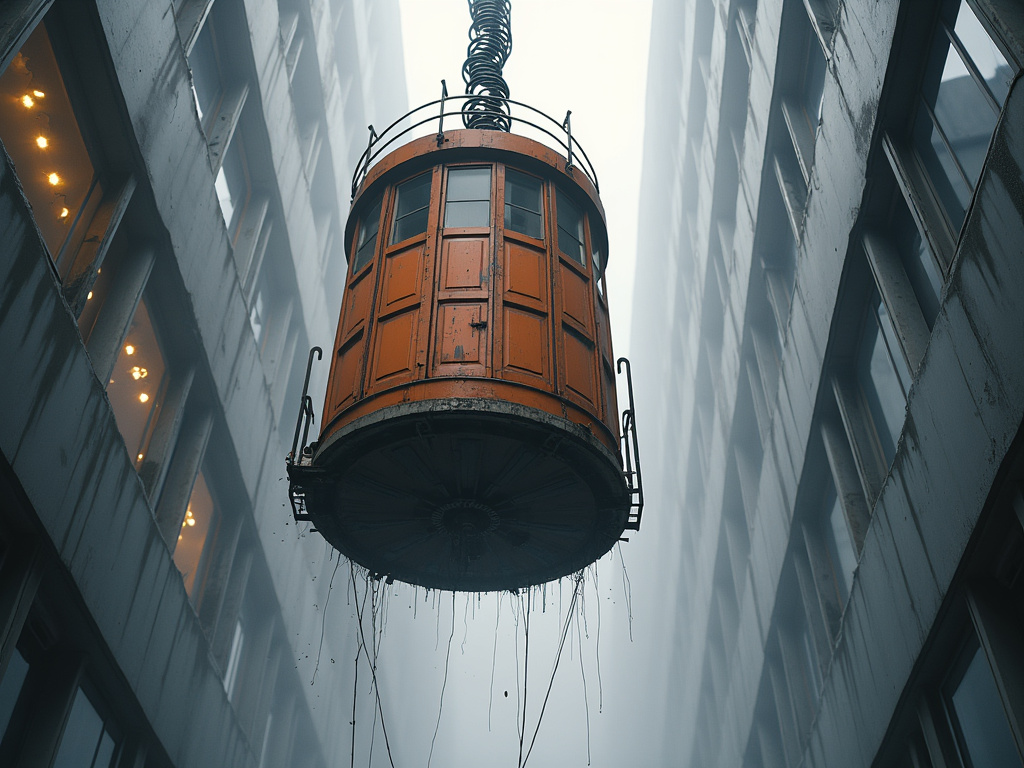

### ASR


In [209]:
def lift_me_up_before_you_go_go(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):
    
    # Simulations always start at floor 1, so if people are in the lift initially, head up, as far as required (take the max).
    if elev_pop and elevator_floor == 1:
        return min(max(elev_pop), floors) # Use min in case returned floor is > floors.

    # If people are in the lift, keep going if target floor not reached yet.
    if elev_pop and elevator_floor != t_floor:
        return t_floor

    # If people are in the lift, and the target floor has now been reached, head back down, as far as required (take the min).
    if elev_pop and elevator_floor == t_floor:
        return max(min(elev_pop), 1) # Use max in case returned floor is < 1.

    # If there's nobody in the lift...
    if not elev_pop:

        # ...and if there's nobody waiting on any floor, then...
        if all(x == 0 for x in floor_population):

            # ...if it's morning or post-lunch, head to floor 1, since most people will probably want to enter the building...
            if timestamp.hour < 10 or 13 <= timestamp.hour < 14:
                return 1

            # ...otherwise head to the top floor, given most people will probably want to exit the building...
            else:
                return floors

        # ...but if there are people waiting on different floors, then...
        elif elevator_floor == t_floor:

            # ...head to the floor with the most people waiting
            most_desired_floor = floor_population.index(max(floor_population))
            return most_desired_floor

    # In all other cases, keep heading to the target floor.
    return t_floor


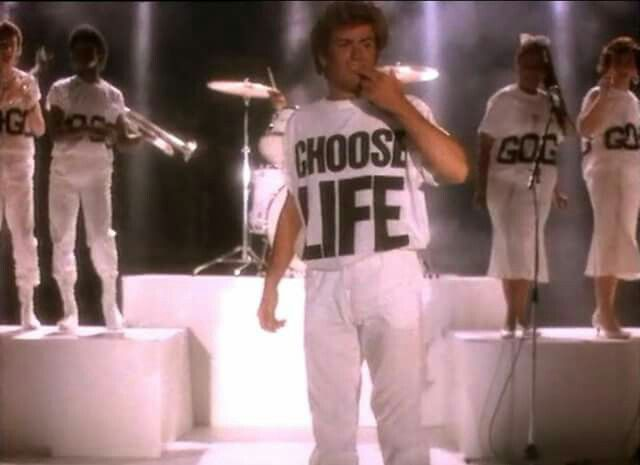

### Majority Rules

In [210]:

def m_algorithm(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):
    people_wanting_to_go_up = [floor for floor in elev_pop if floor > elevator_floor]
    people_wanting_to_go_down = [floor for floor in elev_pop if floor < elevator_floor]
   
    if not elev_pop:  # If the elevator is empty head to the busiest floor
        if elevator_floor == 1:    # If on the bottom floor, go up 
            t_floor = elevator_floor + 1
        else:
            busiest_floor = floor_population.index(max(floor_population))    # find the index of the busiest floor
            t_floor = busiest_floor if floor_population[busiest_floor] > 0 else elevator_floor
    elif len(people_wanting_to_go_up) > len(people_wanting_to_go_down) and elevator_floor!=floors:   # If more people want to go up, then down, go up
        t_floor = elevator_floor + 1
    elif len(people_wanting_to_go_down) >= len(people_wanting_to_go_up) and elevator_floor !=1:    #If more people want to go down, then up, go down
        t_floor = elevator_floor - 1
    else:
        t_floor = elevator_floor  # If there is no majority direction, stay on the current floor.

    return t_floor

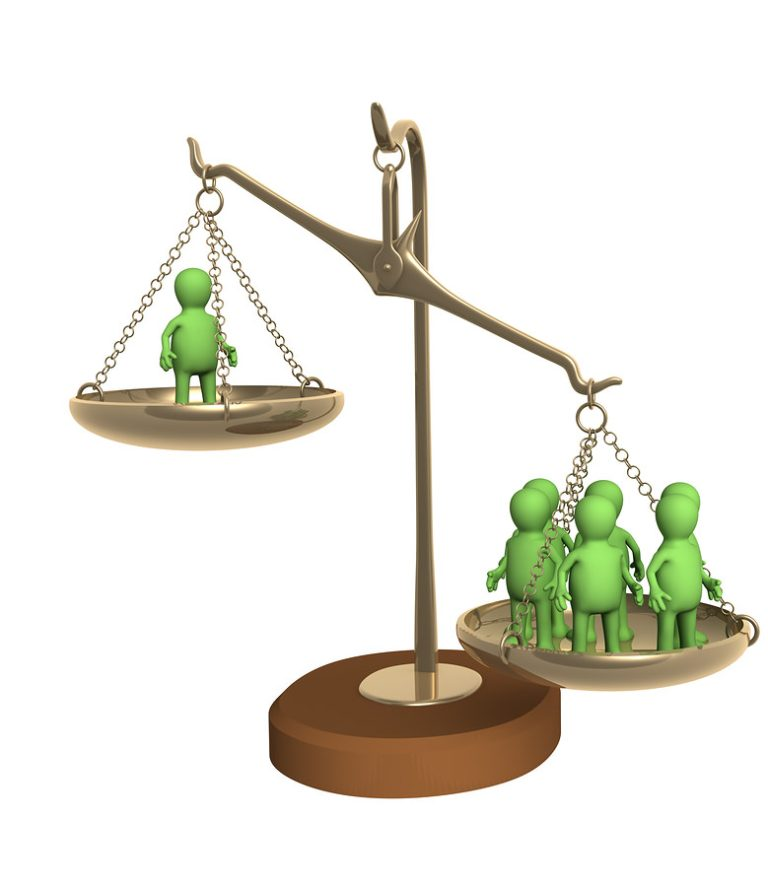


### The Concierge

In [211]:
# The Concierge
def concierge(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):

  target = 0

  going_up = len([x for x in elev_pop if x < elevator_floor])
  going_down = len([x for x in elev_pop if x > elevator_floor])

  people_above = 0
  people_below = 0

  for n in range(len(floor_population)):
    if n < elevator_floor and floor_population[n] > 0:
      people_above = people_above + floor_population[n]
    if n > elevator_floor and floor_population[n] > 0:
      people_below = people_below + floor_population[n]

  avg_up = 0
  avg_down = 0
  avg_above = 0
  avg_below = 0

  if elevator_floor != 1:
    avg_up = going_up / (elevator_floor-1)
    avg_above = people_above / (elevator_floor-1)

  if elevator_floor != floors:
    avg_down = going_down / (floors - elevator_floor)
    avg_below = people_below / (floors - elevator_floor)

  if len(elev_pop) > 0:
    if avg_up > avg_down:
      target = 1
    elif avg_up < avg_down:
      target = floors
    elif (elevator_floor-1) < (floors - elevator_floor):
      target = 1
    else:
      target = floors


  elif max(floor_population) > 0:
      if avg_above > avg_below:
        target = 1
      elif avg_above < avg_below:
        target = floors
      elif (elevator_floor-1) < (floors - elevator_floor):
        target = 1
      else:
        target = floors

  else:
    target = round(floors / 2)

  return target

### Efficient Elevator Ryan

In [212]:
def efficient_elevator_ryan(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):
    def get_base_floor(timestamp):
        if timestamp.hour < 10 or 13 <= timestamp.hour < 14:
            return 1
        else:
            return int(floors/2)
            
    if elev_pop:
        return min(elev_pop, key=lambda x: abs(x-elevator_floor))
    else:
        floors_with_people = [i for i, pop in enumerate(floor_population) if not pop == 0]
        if floors_with_people:
            return min(floors_with_people, key=lambda x: abs(x-elevator_floor))
        return get_base_floor(timestamp)

### Inside Job

In [213]:
def inside_job(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):
    if len(elev_pop) > 0:
        distances = [abs(elevator_floor-requested_floor) for requested_floor in elev_pop]
        r_floor = elev_pop[distances.index(min(distances))]
    elif sum(floor_population) > 0:
        r_floor = floor_population.index(max(floor_population)) # This is wrong but the thing gets stuck on 2 otherwise!
    else:
        r_floor = int(floors/2)
    return r_floor

### Manifest Democracy

In [214]:
# Manifest Democracy
def manifest_democracy(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):

    # “Democracy is the worst form of government, except for all the others.” -Winston Churchill

    # Welcome to the Vertical House of Representatives!
    # In this elevator, there is no left or right — only up and down.
    # Ideologies don't matter, only altitudes.
    from collections import Counter
    floor_votes = Counter()
    # max_elevator_capacity = 15

    # Allow the occupants of the elvator to vote
    def this_is_democracy_manifest(elev_pop):
        return Counter(elev_pop)

    # Allow the people waiting on each floor to vote
    def are_you_waiting_to_receive_my_elevator(floor_population):
        if sum(floor_population) == 0:
            return None
        return floor_population.index(max(floor_population))

    # Add 3 votes for floor 1 during lunchtime if it already has a vote
    def succulent_chinese_meal(timestamp, floor_votes):
        lunch_start = time(12, 0)
        lunch_end = time(13, 30)
        if lunch_start <= timestamp.time() <= lunch_end and floor_votes.get(1, 0) > 0:
            floor_votes[1] += 3

    # Add 3 votes for floor 1 in the morning if it already has a vote
    def thats_a_nice_morning_sir(timestamp, floor_votes):
        morning_start = time(7, 0)
        morning_end = time(10, 0)
        if morning_start <= timestamp.time() <= morning_end and floor_votes.get(1, 0) > 0:
            floor_votes[1] += 3

    # Get votes from elevator occupants
    floor_votes.update(this_is_democracy_manifest(elev_pop))

    # If no one in the elevator is going to the waiting floor,
    # they don't get a vote...
    waiting_floor = are_you_waiting_to_receive_my_elevator(floor_population)
    if waiting_floor is not None:
        if waiting_floor in elev_pop:
            floor_votes[waiting_floor] += floor_population[waiting_floor]
        elif not elev_pop:  # If the elevator is empty
            floor_votes[waiting_floor] += floor_population[waiting_floor]

    # Add bias
    succulent_chinese_meal(timestamp, floor_votes)
    thats_a_nice_morning_sir(timestamp, floor_votes)

    if floor_votes:
        # Check for ties
        top_floors = floor_votes.most_common()
        max_votes = top_floors[0][1]
        tied_floors = [floor for floor, votes in top_floors if votes == max_votes]

        if len(tied_floors) > 1:  # There's a tie
            if t_floor > elevator_floor:
                target_floor = floors
            elif t_floor < elevator_floor:
                target_floor = 1
            else:  # t_floor == elevator_floor
                target_floor = random.choice(tied_floors)
        else:
            # No tie, choose the floor with the most votes
            target_floor = tied_floors[0]
    else:
        # No votes? Let's aim for the middle.
        target_floor = round(floors / 2)

    return target_floor

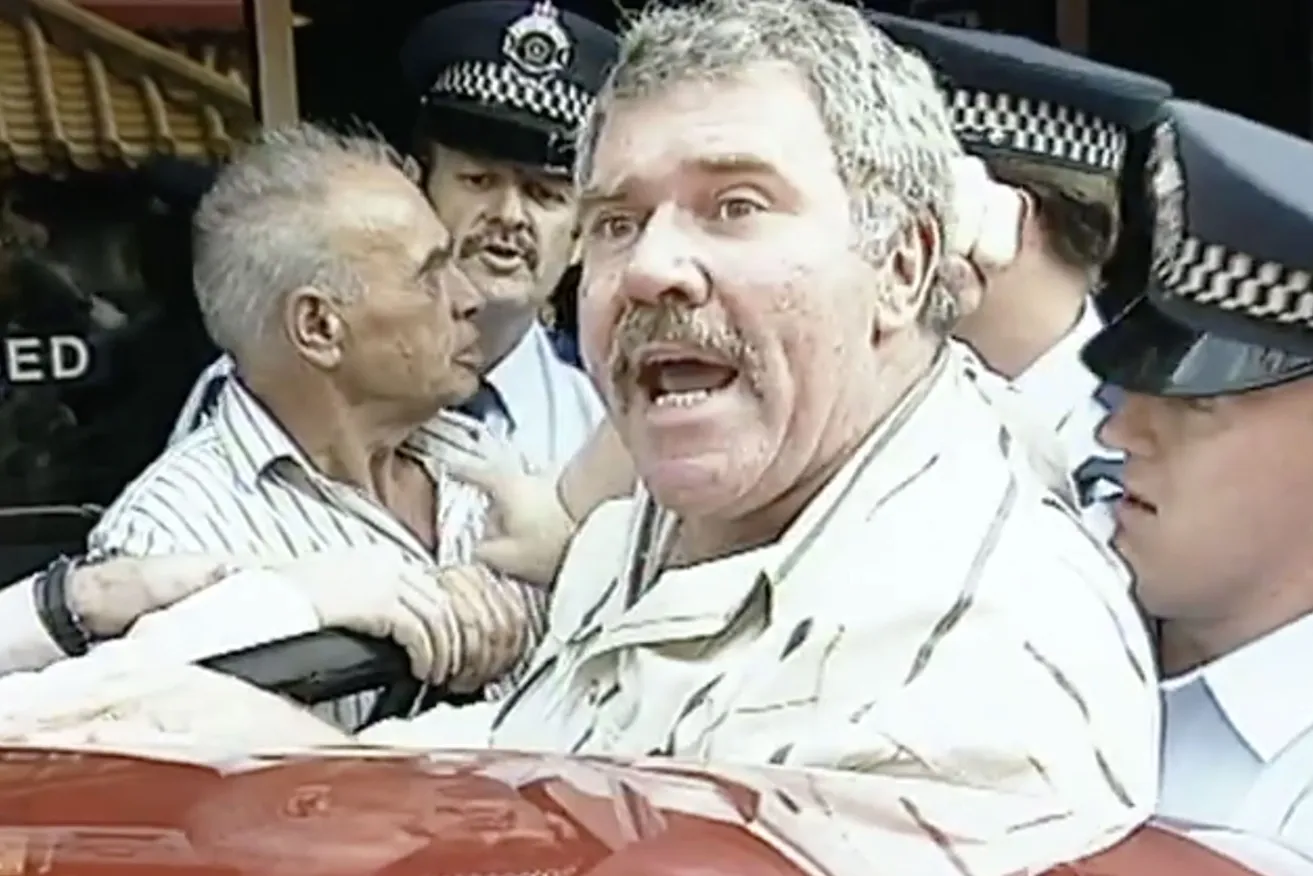


### Astar_MC

In [215]:
# Astar_MC
def astar_mc(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):
    # Author: Axel Ahmer

    import heapq
    from typing import List, Tuple
    from datetime import datetime, timedelta
    import random
    from collections import Counter

    class ElevatorState:
        __slots__ = ('timestamp', 'elevator_floor',
                     'elev_pop', 'floor_population', 'floors')

        def __init__(self, timestamp, elevator_floor, elev_pop, floor_population, floors):
            self.timestamp = timestamp
            self.elevator_floor = int(elevator_floor)
            self.elev_pop = tuple(sorted(elev_pop))
            self.floor_population = tuple(floor_population)
            self.floors = floors

        def __lt__(self, other):
            return self.timestamp < other.timestamp

        def __eq__(self, other):
            return (self.elevator_floor, self.elev_pop, self.floor_population) == \
                   (other.elevator_floor, other.elev_pop, other.floor_population)

        def __hash__(self):
            return hash((self.elevator_floor, self.elev_pop, self.floor_population))

    def random_destination(current_floor: int, floors: int, num_passengers: int) -> List[int]:
        return [random.randint(1, floors - 1) + (current_floor < random.randint(1, floors)) for _ in range(num_passengers)]

    def best_idle_location(floors: int, timestamp: datetime) -> int:
        hour = timestamp.hour
        if hour < 10:  # Morning rush
            return 1
        elif 11 <= hour < 14:  # Lunch time
            return floors // 2 + 1
        elif hour >= 16:  # Evening rush
            return floors
        else:  # Normal hours
            return floors // 2

    def astar_search(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):
        max_depth = 128
        max_capacity = 4  # change if simulation bug gets fixed to 6.
        elevator_floor = int(elevator_floor)

        def heuristic(state: ElevatorState) -> int:
            floors_to_visit = set(state.elev_pop)
            floors_to_visit.update(floor for floor, pop in enumerate(
                state.floor_population) if pop > 0)
            floors_to_visit.add(state.elevator_floor)
            idle_floor = best_idle_location(state.floors, state.timestamp)

            if len(floors_to_visit) <= 1:
                return abs(state.elevator_floor - idle_floor)

            min_floor, max_floor = min(floors_to_visit), max(floors_to_visit)
            range1, range2 = state.elevator_floor - \
                min_floor, max_floor - state.elevator_floor
            smaller_range, larger_range = min(
                range1, range2), max(range1, range2)
            work_cost = 2 * smaller_range + larger_range
            idle_cost = max(abs(idle_floor - min_floor),
                            abs(idle_floor - max_floor))
            return work_cost + idle_cost

        def get_neighbors(state: ElevatorState) -> List[ElevatorState]:
            neighbors = []
            possible_floors = [state.elevator_floor - 1,
                               state.elevator_floor, state.elevator_floor + 1]
            possible_floors = [
                f for f in possible_floors if 1 <= f <= state.floors]

            new_timestamp = state.timestamp + timedelta(seconds=5)
            for new_floor in possible_floors:
                new_elev_pop = [p for p in state.elev_pop if p != new_floor]
                new_floor_population = list(state.floor_population)

                if new_floor_population[new_floor] > 0 and len(new_elev_pop) < max_capacity:
                    passengers_entering = min(
                        new_floor_population[new_floor], max_capacity - len(new_elev_pop))
                    new_floor_population[new_floor] -= passengers_entering
                    new_destinations = random_destination(
                        new_floor, state.floors, passengers_entering)
                    new_elev_pop.extend(new_destinations)

                neighbors.append(ElevatorState(
                    new_timestamp, new_floor, new_elev_pop, new_floor_population, state.floors))

            return neighbors

        initial_state = ElevatorState(
            timestamp, elevator_floor, elev_pop, floor_population, floors)
        open_set = [(0, initial_state)]
        came_from = {}
        g_score = {initial_state: 0}
        f_score = {initial_state: heuristic(initial_state)}

        while open_set:
            current_state = heapq.heappop(open_set)[1]

            if g_score[current_state] >= max_depth:
                break

            if not current_state.elev_pop and not any(current_state.floor_population):
                path = []
                state = current_state
                while state in came_from:
                    path.append(state.elevator_floor)
                    state = came_from[state]
                path.reverse()
                path.append(best_idle_location(
                    current_state.floors, current_state.timestamp))
                return path[0] if path else elevator_floor

            for neighbor in get_neighbors(current_state):
                tentative_g_score = g_score[current_state] + 1

                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current_state
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + heuristic(neighbor)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))

        best_next_state = min(
            came_from.keys(), key=lambda state: f_score.get(state, float('inf')))
        while came_from.get(best_next_state) != initial_state:
            best_next_state = came_from[best_next_state]

        return best_next_state.elevator_floor

    def print_state(floor_pop, elevator_floor, elev_pop):
        state_array = []
        for floor in range(1, len(floor_pop)):
            if floor == elevator_floor:
                elevator_contents = ','.join(map(str, sorted(elev_pop)))
                state_array.append(f"[[{elevator_contents}]]")
            else:
                state_array.append(str(floor_pop[floor]))
        state_str = ','.join(state_array)
        return f"{timestamp}, [{state_str}] (Left: Ground Floor, Right: Top Floor)"

    if elevator_floor % 1 != 0:
        return t_floor

    if sum(floor_population) > 16:
        if elevator_floor == 1:
            return floors
        elif elevator_floor == floors:
            return 1
        elif t_floor == elevator_floor:
            return t_floor + 1
        else:
            return t_floor

    num_searches = 15
    next_moves = []

    for _ in range(num_searches):
        next_move = astar_search(
            timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor)
        next_moves.append(next_move)

    most_common_move = Counter(next_moves).most_common(1)[0][0]

    # print(print_state(floor_population, elevator_floor, elev_pop))
    # print(f'Next moves: {next_moves}')
    # print(f"Next move: {most_common_move}")
    # print("---")

    return most_common_move

### Michellevator

In [216]:
def michellevator(timestamp, elev_pop, floor_population, floors, elevator_floor, t_floor):
    """ smart up and down

    """
    delta = t_floor - elevator_floor
    if delta > 0:
        # elevator needs to go up

        # find the highest floor with someone waiting
        highest_floor_waiting = floors
        if np.sum(floor_population) > 0:
            while floor_population[highest_floor_waiting] == 0:
                highest_floor_waiting -= 1
                if highest_floor_waiting == 1:
                    break
        else:
            highest_floor_waiting = 1

        # find the highest floor destination
        if len(elev_pop) > 0:
            highest_floor_destination = np.max(elev_pop)
        else:
            highest_floor_destination = 1

        # get the overall highest value of the two
        t_floor = np.max([highest_floor_waiting, highest_floor_destination])

        return t_floor

    elif delta < 0:
        # need to go down
        # find the lowest floor with someone waiting
        lowest_floor_waiting = 1
        if np.sum(floor_population) > 0:
            while floor_population[lowest_floor_waiting] == 0:
                lowest_floor_waiting += 1
                if lowest_floor_waiting == floors:
                    break
        else:
            lowest_floor_waiting = floors

        # lowest floor destination
        if len(elev_pop) > 0:
            lowest_floor_destination = np.min(elev_pop)
        else:
            lowest_floor_destination = floors

        # overall min of the two
        t_floor = np.min([lowest_floor_waiting, lowest_floor_destination])

        return t_floor

    else:
        # delta = 0
        # currently at target floor
        # go to bottom floor if not already there, if already there go to top
        if elevator_floor == 1:
            return floors
        else:
            return 1


## Functions Dict

In [217]:
# Creating a dictionary to map keys to functions
function_dict = {
    "efficient_time_of_day": efficient_time_of_day,
    "baseline_algorithm": baseline_algorithm,
    #"harmonic_oscillator": harmonic_oscillator,
    "lift_me_up_before_you_go_go": lift_me_up_before_you_go_go,
    "m_algorithm": m_algorithm,
    "concierge": concierge,
    "efficient_elevator_ryan": efficient_elevator_ryan,
    "inside_job": inside_job,
    "manifest_democracy": manifest_democracy,
    "astar_mc": astar_mc,
    "michellevator": michellevator
    
}

---


# Round 1

## Set Uplift Simulation Parameters

In [218]:
# Parameters
num_entries = 200  # Number of people
floors = 4  # Number of floors in the building
start_date = datetime(2024, 8, 1, 8, 0)  # Start time
end_date = datetime(2024, 8, 1, 10, 0)  # End time

## Create Entries DataFrame

In [219]:
entries_df = create_entries_df(num_entries, floors, start_date, end_date)
entries_df.head()

Timestamp  Entry_Floor  Exit_Floor
30  2024-08-01 08:00:50            1           2
138 2024-08-01 08:01:04            1           2
24  2024-08-01 08:02:03            3           4
199 2024-08-01 08:02:07            2           1
26  2024-08-01 08:02:17            1           2

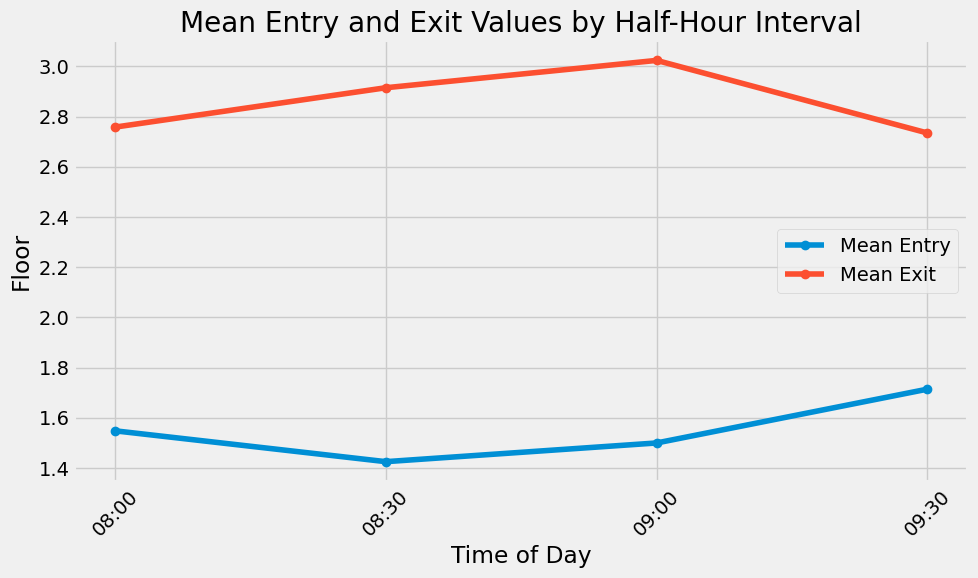

In [220]:
# Show line chart with entry and exits by time of day
plot_mean_floor_by_half_hour(entries_df)

## Run simulations

In [221]:
all_wait_times = {}
for function in function_dict:
    print(f'-----------------')
    print(f'Function: {function}')
    wait_times = single_simulation(algorithm=function, function_dict=function_dict, data=entries_df, floors=floors, max_elevator_capacity=6, animate=False, animation_speed=0.1)
    all_wait_times[function] = wait_times

-----------------
Function: efficient_time_of_day
-----------------
Function: baseline_algorithm
-----------------
Function: lift_me_up_before_you_go_go
-----------------
Function: m_algorithm
-----------------
Function: concierge
-----------------
Function: efficient_elevator_ryan
-----------------
Function: inside_job
-----------------
Function: manifest_democracy
-----------------
Function: astar_mc
-----------------
Function: michellevator


In [222]:
# Create lists to hold the results
keys = []
mins = []
maxs = []
means = []

# Iterate over the dictionary and calculate min, max, and mean
for key, values in all_wait_times.items():
    keys.append(key)
    mins.append(min(values))
    maxs.append(max(values))
    means.append(round(np.mean(values), 4))

# Create a pandas DataFrame
df = pd.DataFrame({
    'Name': keys,
    'Shortest Wait': mins,
    'Longest Wait': maxs,
    'Average Wait': means,
})

# Sort by average wait and adjust index
df = df.sort_values(by='Average Wait', ascending=True).reset_index(drop=True)
df.index = df.index + 1
df1 = df

df1


Name  Shortest Wait  Longest Wait  Average Wait
1       efficient_elevator_ryan              4            17         7.620
2   lift_me_up_before_you_go_go              4            17         7.720
3                      astar_mc              3            24         7.790
4                 michellevator              3            18         8.180
5                     concierge              3            16         8.245
6         efficient_time_of_day              4            19         8.295
7                    inside_job              4            19         8.345
8            manifest_democracy              4            19         8.345
9                   m_algorithm              3            20         8.650
10           baseline_algorithm              3            18         9.925

In [223]:
# Points for this round
points_df1 = award_points(df1)
points_df1

Name  Points
1       efficient_elevator_ryan       9
2   lift_me_up_before_you_go_go       8
3                      astar_mc       7
4                 michellevator       6
5                     concierge       5
6         efficient_time_of_day       4
7                    inside_job       3
8            manifest_democracy       2
9                   m_algorithm       1
10           baseline_algorithm       0

## Create subplots

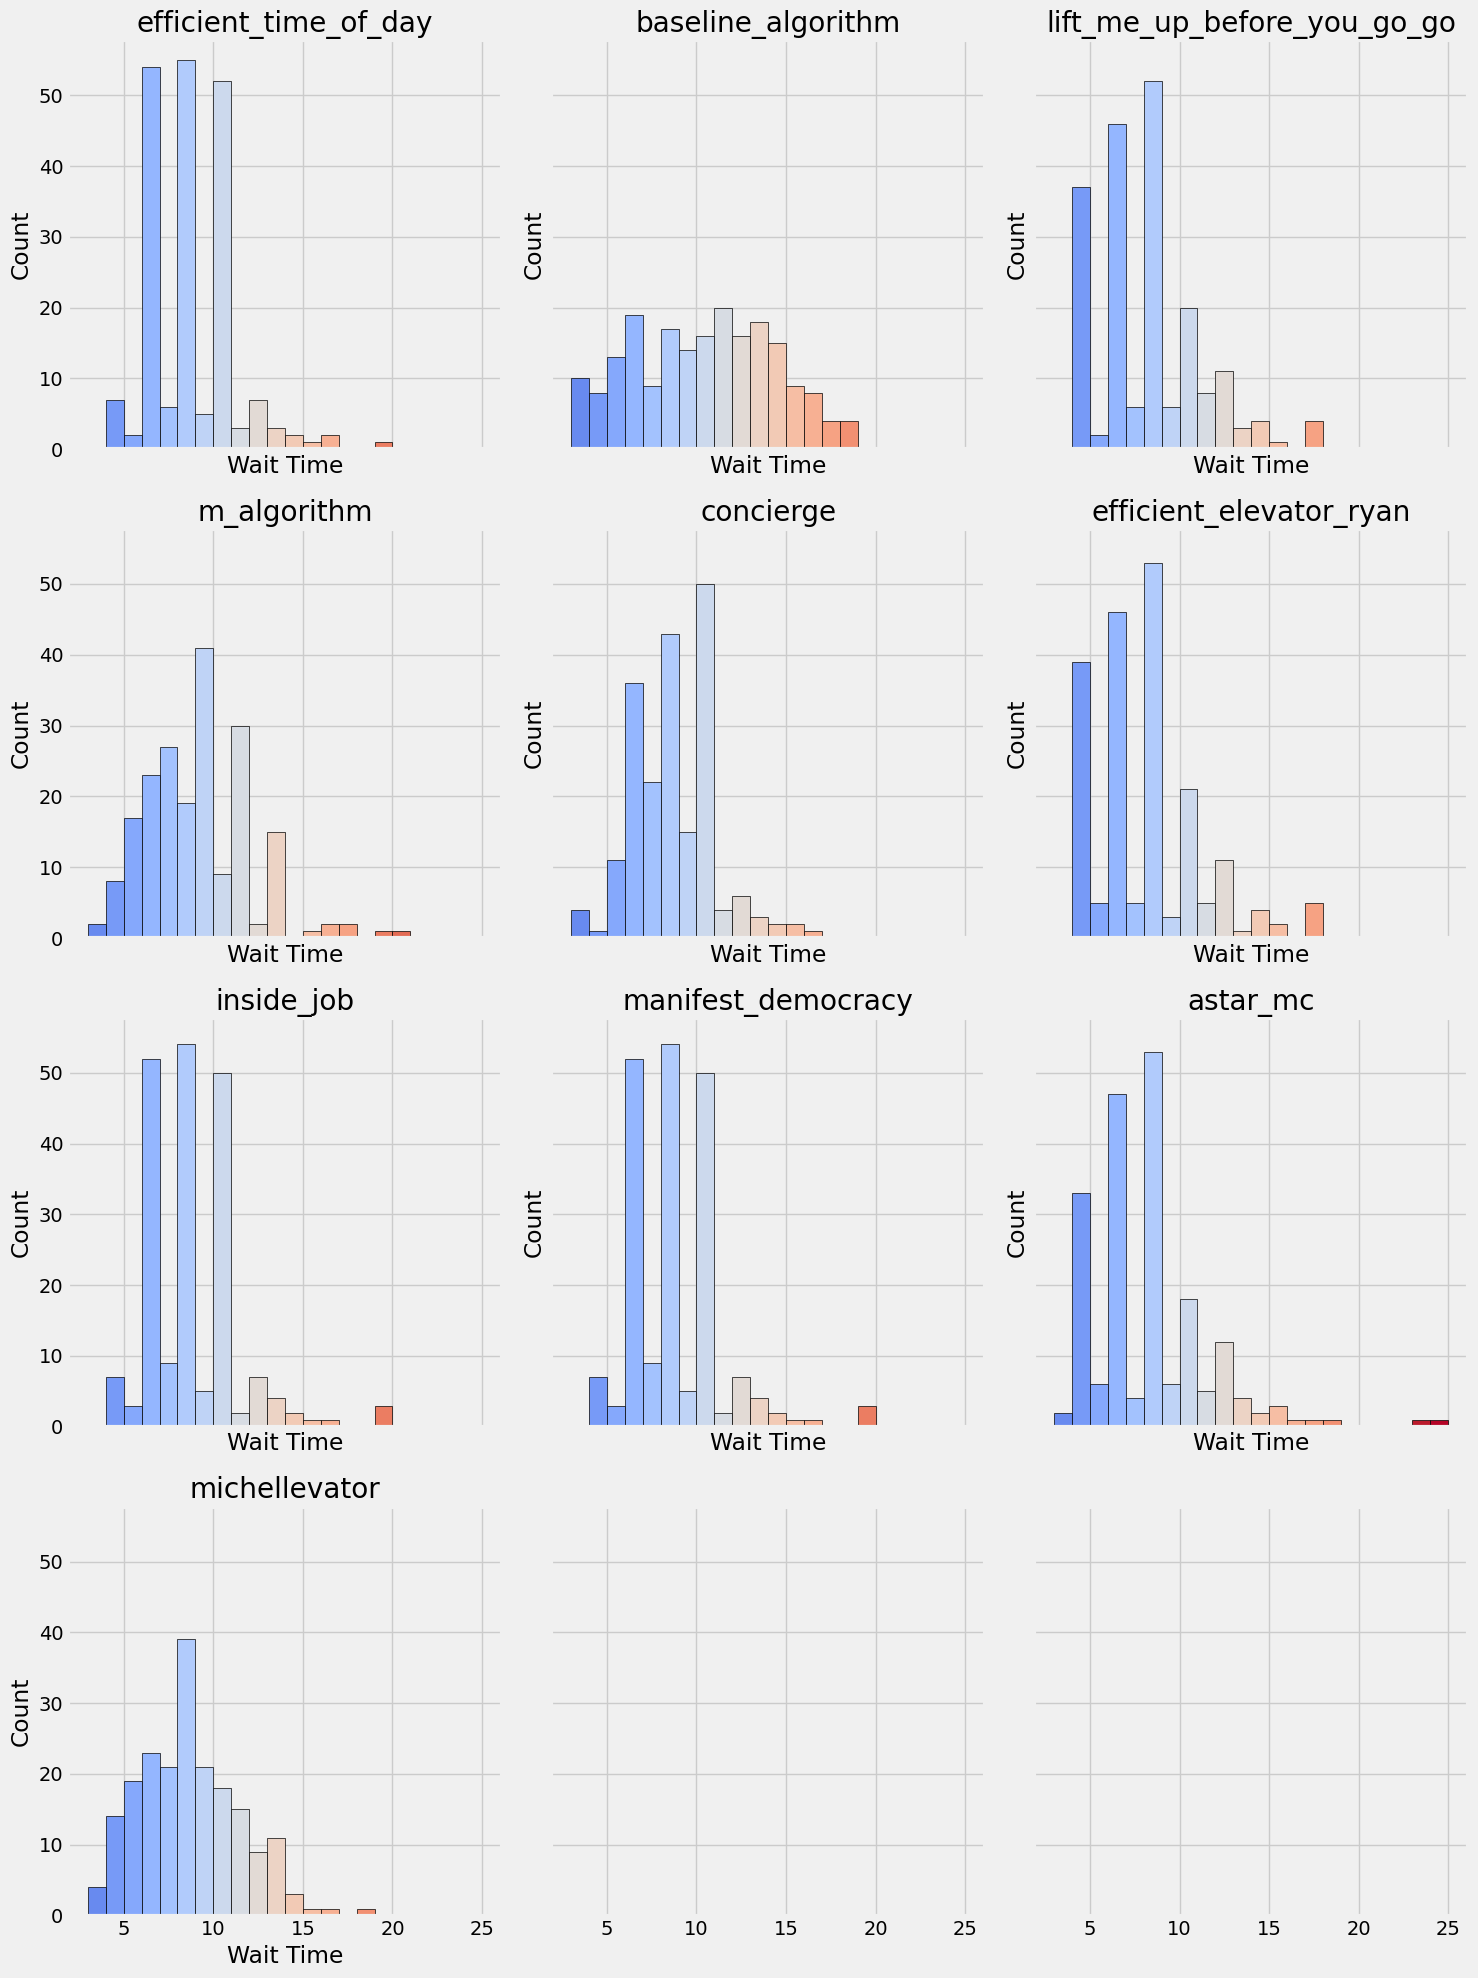

In [224]:
# Create subplots
# Maximum number of subplots per row
max_cols = 3

# Determine the number of rows and columns
num_subplots = len(function_dict)
num_rows = math.ceil(num_subplots / max_cols)
num_cols = min(num_subplots, max_cols)

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, tight_layout=True, figsize=(15, 5 * num_rows))

# If there's only one row or one column, axs won't be a 2D array, so we need to handle that
axs = axs.flatten() if num_subplots > 1 else [axs]

# Normalize and create colormap for wait times
max_wait_time = max(value for values in all_wait_times.values() for value in values)
norm = mcolors.Normalize(vmin=0, vmax=max_wait_time)
cmap = plt.get_cmap('coolwarm')  # Blue (low) to Red (high)

# Plot histograms for each algorithm in a separate subplot
for ax, (name, values) in zip(axs, all_wait_times.items()):
    # Create a histogram
    counts, bins = np.histogram(values, bins=range(min(values), max(values) + 2))

    # Assign colors based on the mid-point of each bin
    bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Calculate bin centers
    colors = cmap(norm(bin_centers))  # Map bin centers to colors

    # Plot the histogram with the corresponding colors
    ax.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color=colors, edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Wait Time')
    ax.set_ylabel('Count')
    ax.grid(True)

# Display the plot
plt.show()

---
# Round 2

## Set Uplift Simulation Parameters

In [225]:
# Parameters
num_entries = 2000  # Number of people
floors = 8  # Number of floors in the building
start_date = datetime(2024, 8, 1, 15, 0)  # Start time
end_date = datetime(2024, 8, 1, 17, 0)  # End time

## Create Entries DataFrame

In [226]:
entries_df = create_entries_df(num_entries, floors, start_date, end_date)
entries_df.head()

Timestamp  Entry_Floor  Exit_Floor
1512 2024-08-01 15:00:00            2           8
1868 2024-08-01 15:00:00            2           3
442  2024-08-01 15:00:09            8           3
930  2024-08-01 15:00:10            7           3
1046 2024-08-01 15:00:20            6           1

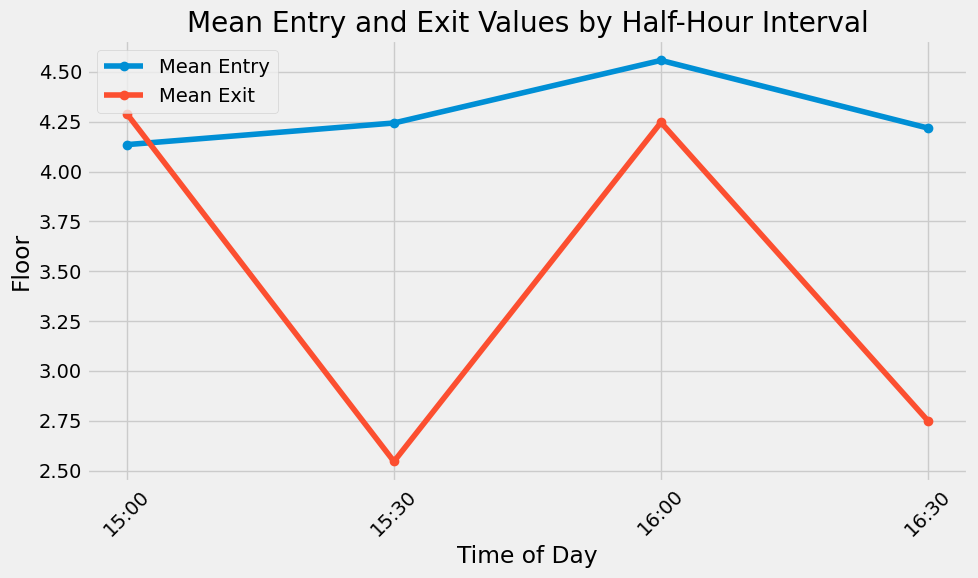

In [227]:
# Show line chart with entry and exits by time of day
plot_mean_floor_by_half_hour(entries_df)

## Run simulations

In [228]:
all_wait_times = {}
for function in function_dict:
    print(f'-----------------')
    print(f'Function: {function}')
    wait_times = single_simulation(algorithm=function, function_dict=function_dict, data=entries_df, floors=floors, max_elevator_capacity=6, animate=False, animation_speed=0.1)
    all_wait_times[function] = wait_times

-----------------
Function: efficient_time_of_day
-----------------
Function: baseline_algorithm
-----------------
Function: lift_me_up_before_you_go_go
-----------------
Function: m_algorithm
-----------------
Function: concierge
-----------------
Function: efficient_elevator_ryan
-----------------
Function: inside_job
-----------------
Function: manifest_democracy
-----------------
Function: astar_mc
astar_mc timed out!
-----------------
Function: michellevator


In [229]:
# Create lists to hold the results
keys = []
mins = []
maxs = []
means = []

# Iterate over the dictionary and calculate min, max, and mean
for key, values in all_wait_times.items():
    keys.append(key)
    mins.append(min(values))
    maxs.append(max(values))
    means.append(round(np.mean(values), 4))

# Create a pandas DataFrame
df = pd.DataFrame({
    'Name': keys,
    'Shortest Wait': mins,
    'Longest Wait': maxs,
    'Average Wait': means,
})

# Sort by average wait and adjust index
df = df.sort_values(by='Average Wait', ascending=True).reset_index(drop=True)
df.index = df.index + 1

df2 = df
df2

Name  Shortest Wait  Longest Wait  Average Wait
1                 michellevator              3           120       22.7215
2            baseline_algorithm              3           257       23.7165
3   lift_me_up_before_you_go_go              3           212       24.8370
4            manifest_democracy              3          1257       32.9920
5                    inside_job              3          1370       34.5505
6                     concierge              3          1655       44.0890
7         efficient_time_of_day              3          2297       48.5975
8       efficient_elevator_ryan              3          2297       48.9240
9                      astar_mc              3          2399       53.9551
10                  m_algorithm              3          8170      538.1540

In [230]:
# Points for this round
points_df2 = award_points(df2)
points_df2

Name  Points
1                 michellevator       9
2            baseline_algorithm       8
3   lift_me_up_before_you_go_go       7
4            manifest_democracy       6
5                    inside_job       5
6                     concierge       4
7         efficient_time_of_day       3
8       efficient_elevator_ryan       2
9                      astar_mc       1
10                  m_algorithm       0

## Create subplots

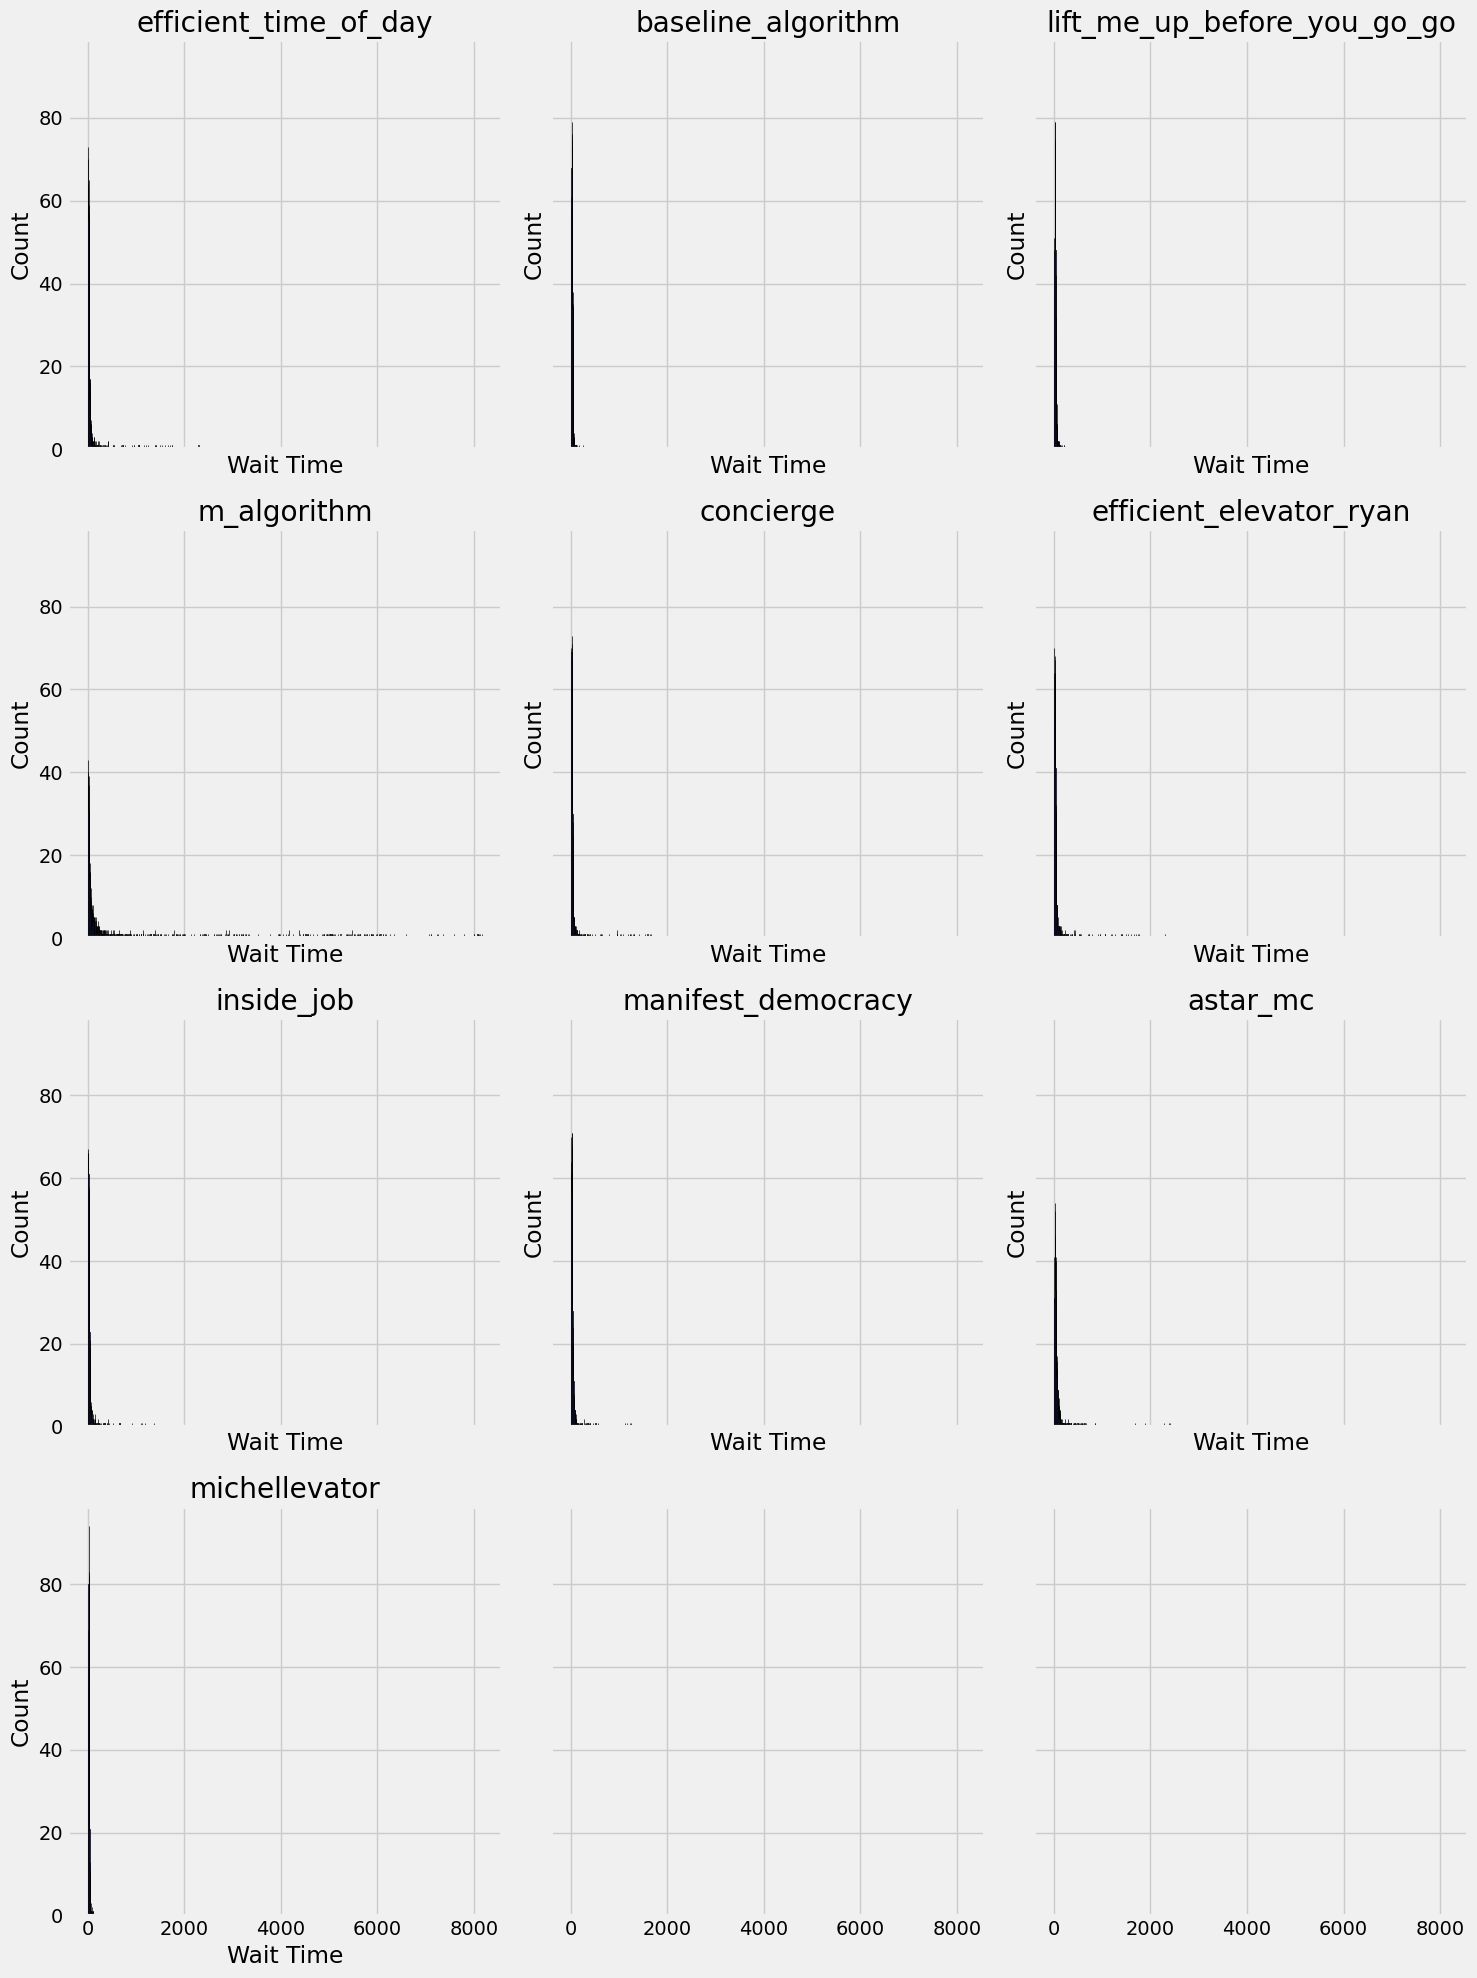

In [231]:
# Create subplots
# Maximum number of subplots per row
max_cols = 3

# Determine the number of rows and columns
num_subplots = len(function_dict)
num_rows = math.ceil(num_subplots / max_cols)
num_cols = min(num_subplots, max_cols)

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, tight_layout=True, figsize=(15, 5 * num_rows))

# If there's only one row or one column, axs won't be a 2D array, so we need to handle that
axs = axs.flatten() if num_subplots > 1 else [axs]

# Normalize and create colormap for wait times
max_wait_time = max(value for values in all_wait_times.values() for value in values)
norm = mcolors.Normalize(vmin=0, vmax=max_wait_time)
cmap = plt.get_cmap('coolwarm')  # Blue (low) to Red (high)

# Plot histograms for each algorithm in a separate subplot
for ax, (name, values) in zip(axs, all_wait_times.items()):
    # Create a histogram
    counts, bins = np.histogram(values, bins=range(min(values), max(values) + 2))

    # Assign colors based on the mid-point of each bin
    bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Calculate bin centers
    colors = cmap(norm(bin_centers))  # Map bin centers to colors

    # Plot the histogram with the corresponding colors
    ax.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color=colors, edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Wait Time')
    ax.set_ylabel('Count')
    ax.grid(True)

# Display the plot
plt.show()

---
# Round 3

## Set Uplift Simulation Parameters

In [232]:
# Parameters
num_entries = 1000  # Number of people
floors = 6  # Number of floors in the building
start_date = datetime(2024, 8, 1, 12, 0)  # Start time
end_date = datetime(2024, 8, 1, 14, 0)  # End time

## Create Entries DataFrame

In [233]:
entries_df = create_entries_df(num_entries, floors, start_date, end_date)
entries_df.head()

Timestamp  Entry_Floor  Exit_Floor
130 2024-08-01 12:00:02            6           1
295 2024-08-01 12:00:05            2           1
168 2024-08-01 12:00:41            4           1
65  2024-08-01 12:00:42            1           3
487 2024-08-01 12:00:53            2           1

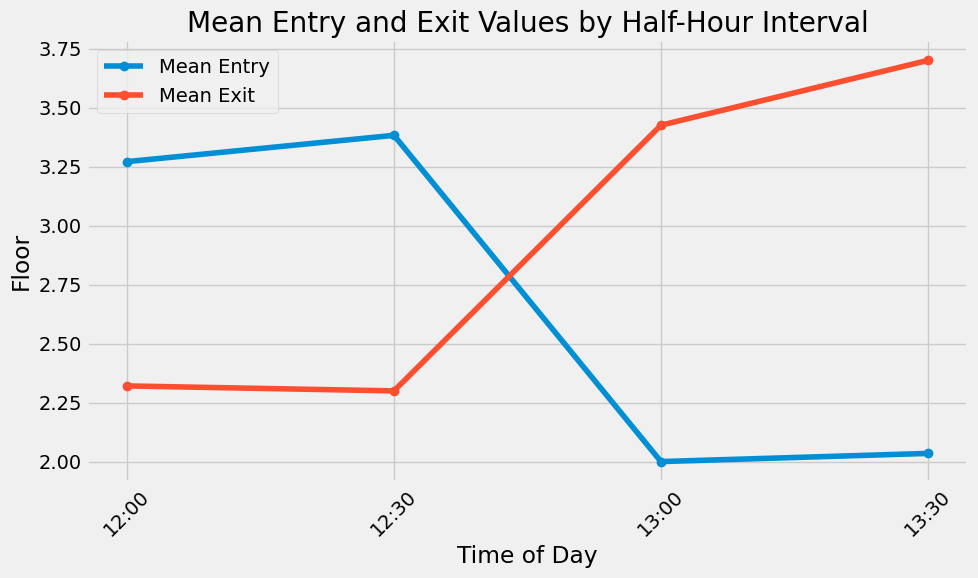

In [234]:
# Show line chart with entry and exits by time of day
plot_mean_floor_by_half_hour(entries_df)

## Run simulations

In [235]:
all_wait_times = {}
for function in function_dict:
    print(f'-----------------')
    print(f'Function: {function}')
    wait_times = single_simulation(algorithm=function, function_dict=function_dict, data=entries_df, floors=floors, max_elevator_capacity=6, animate=False, animation_speed=0.1)
    all_wait_times[function] = wait_times

-----------------
Function: efficient_time_of_day
-----------------
Function: baseline_algorithm
-----------------
Function: lift_me_up_before_you_go_go
-----------------
Function: m_algorithm
-----------------
Function: concierge
-----------------
Function: efficient_elevator_ryan
-----------------
Function: inside_job
-----------------
Function: manifest_democracy
-----------------
Function: astar_mc
-----------------
Function: michellevator


In [236]:
# Create lists to hold the results
keys = []
mins = []
maxs = []
means = []

# Iterate over the dictionary and calculate min, max, and mean
for key, values in all_wait_times.items():
    keys.append(key)
    mins.append(min(values))
    maxs.append(max(values))
    means.append(round(np.mean(values), 4))

# Create a pandas DataFrame
df = pd.DataFrame({
    'Name': keys,
    'Shortest Wait': mins,
    'Longest Wait': maxs,
    'Average Wait': means,
})

# Sort by average wait and adjust index
df = df.sort_values(by='Average Wait', ascending=True).reset_index(drop=True)
df.index = df.index + 1

df3 = df
df3

Name  Shortest Wait  Longest Wait  Average Wait
1                 michellevator              3            47        14.451
2                     concierge              3           122        15.340
3   lift_me_up_before_you_go_go              3            62        15.757
4            baseline_algorithm              3            50        16.021
5         efficient_time_of_day              3           119        16.314
6                    inside_job              3           107        16.324
7       efficient_elevator_ryan              3           119        16.351
8            manifest_democracy              3           124        17.830
9                   m_algorithm              3           123        17.887
10                     astar_mc              3           563        27.131

In [237]:
# Points for this round
points_df3 = award_points(df3)
points_df3

Name  Points
1                 michellevator       9
2                     concierge       8
3   lift_me_up_before_you_go_go       7
4            baseline_algorithm       6
5         efficient_time_of_day       5
6                    inside_job       4
7       efficient_elevator_ryan       3
8            manifest_democracy       2
9                   m_algorithm       1
10                     astar_mc       0

## Create subplots

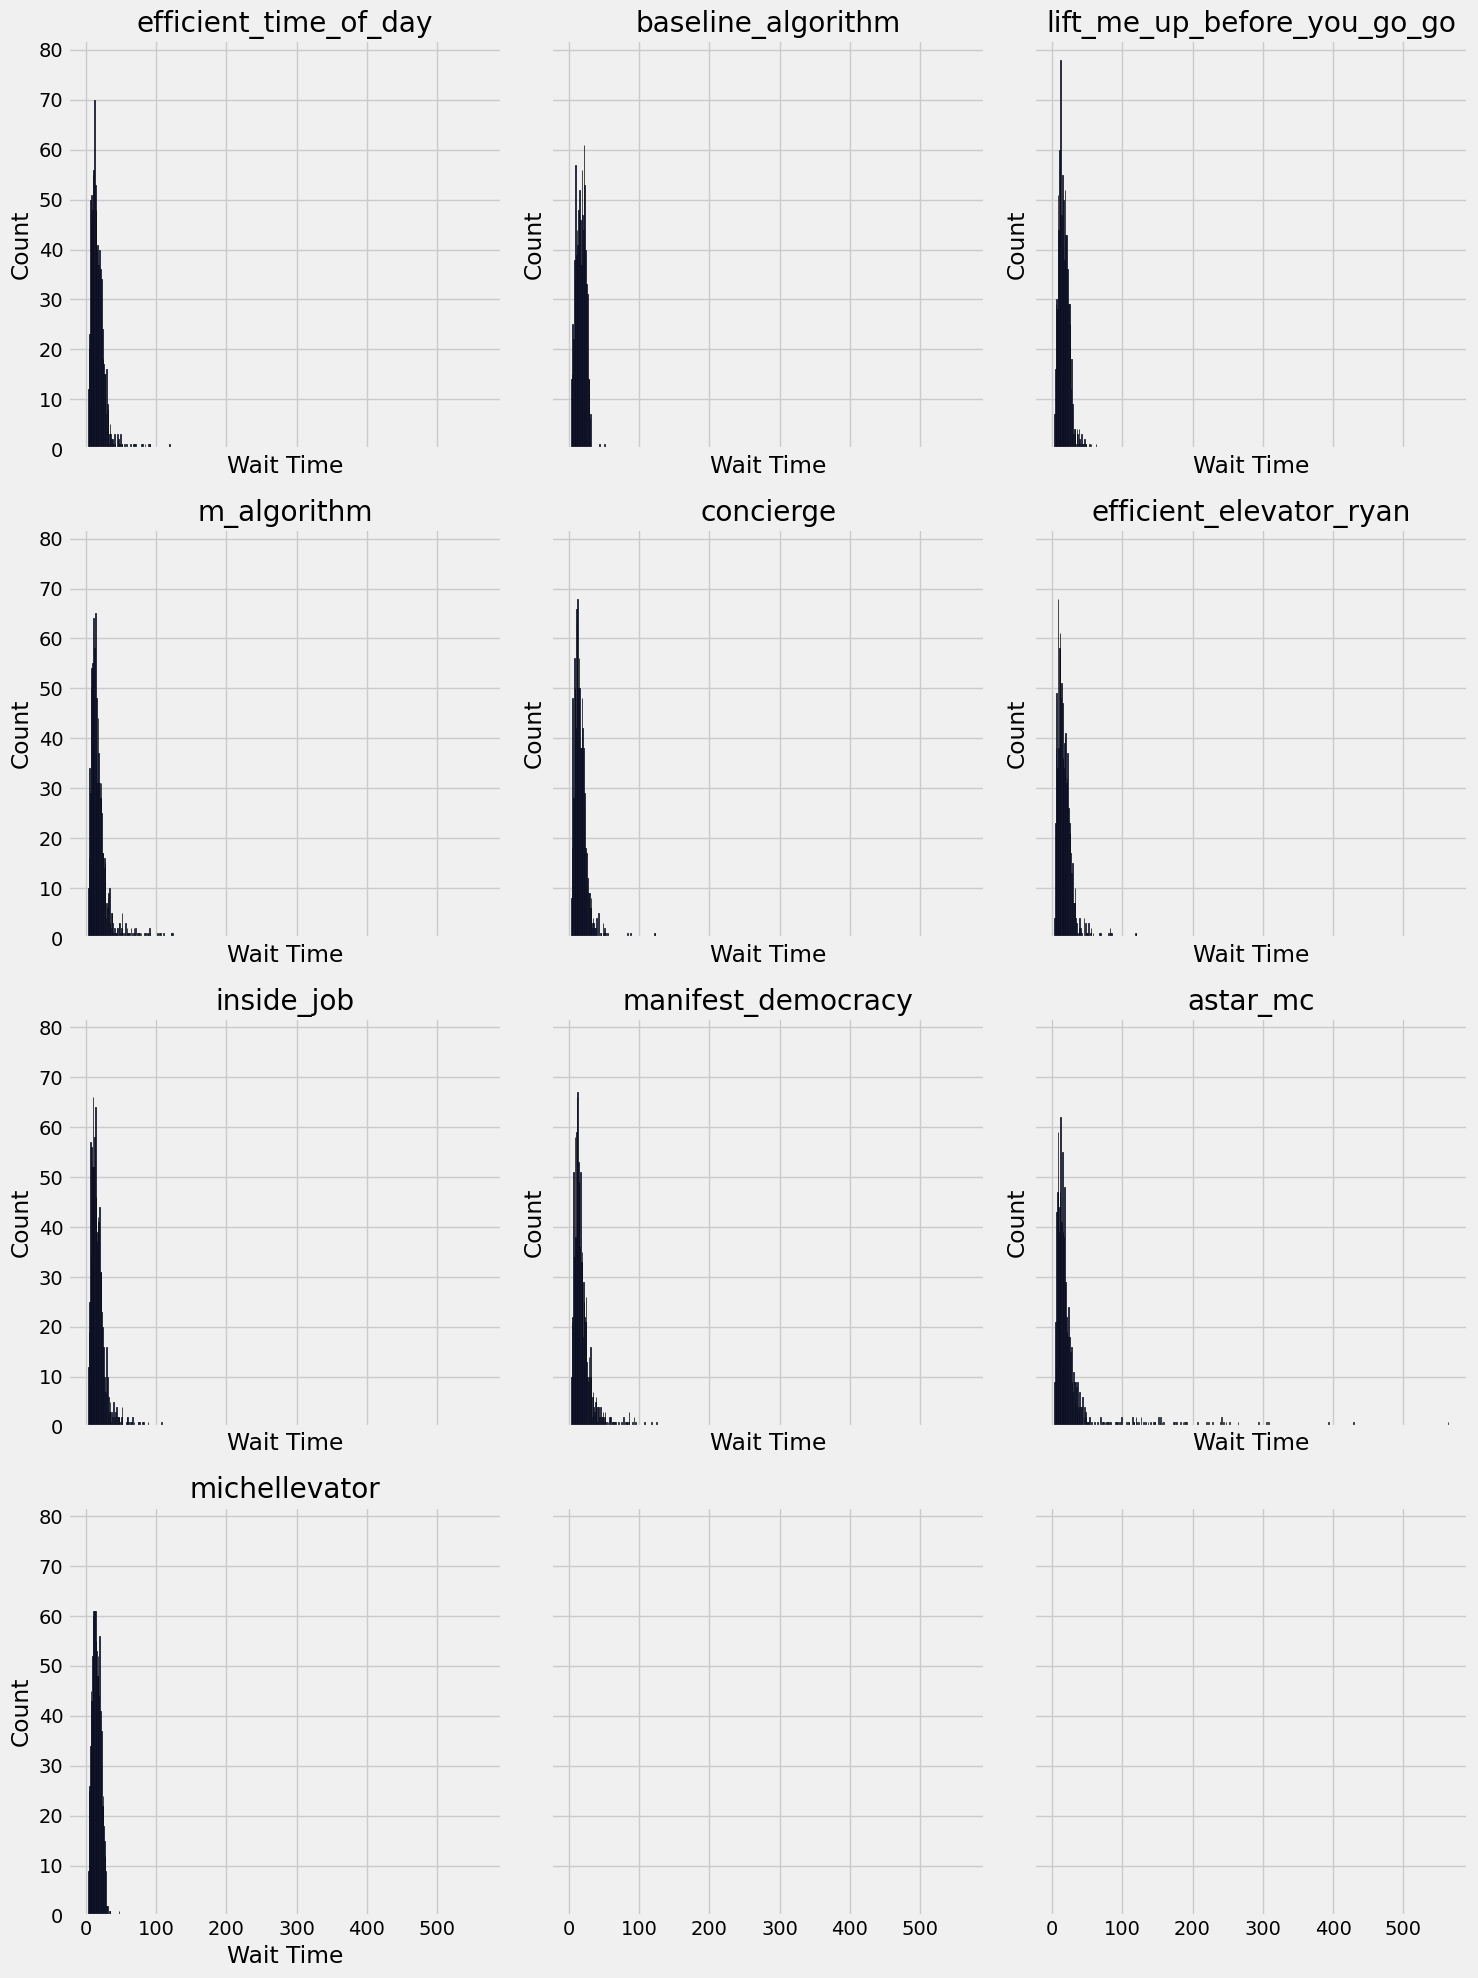

In [238]:
# Create subplots
# Maximum number of subplots per row
max_cols = 3

# Determine the number of rows and columns
num_subplots = len(function_dict)
num_rows = math.ceil(num_subplots / max_cols)
num_cols = min(num_subplots, max_cols)

# Create the subplots
fig, axs = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, tight_layout=True, figsize=(15, 5 * num_rows))

# If there's only one row or one column, axs won't be a 2D array, so we need to handle that
axs = axs.flatten() if num_subplots > 1 else [axs]

# Normalize and create colormap for wait times
max_wait_time = max(value for values in all_wait_times.values() for value in values)
norm = mcolors.Normalize(vmin=0, vmax=max_wait_time)
cmap = plt.get_cmap('coolwarm')  # Blue (low) to Red (high)

# Plot histograms for each algorithm in a separate subplot
for ax, (name, values) in zip(axs, all_wait_times.items()):
    # Create a histogram
    counts, bins = np.histogram(values, bins=range(min(values), max(values) + 2))

    # Assign colors based on the mid-point of each bin
    bin_centers = 0.5 * (bins[1:] + bins[:-1])  # Calculate bin centers
    colors = cmap(norm(bin_centers))  # Map bin centers to colors

    # Plot the histogram with the corresponding colors
    ax.bar(bins[:-1], counts, width=np.diff(bins), align='edge', color=colors, edgecolor='black')
    ax.set_title(name)
    ax.set_xlabel('Wait Time')
    ax.set_ylabel('Count')
    ax.grid(True)

# Display the plot
plt.show()

---
# Aggregated Results

In [239]:
# Concatenate the points DataFrames
all_points = pd.concat([points_df1, points_df2, points_df3])

# Sum points by name
total_points = all_points.groupby('Name')['Points'].sum().reset_index()

# Sort by total points
total_points = total_points.sort_values(by='Points', ascending=False)

In [240]:
total_points

Name  Points
9                michellevator      24
6  lift_me_up_before_you_go_go      22
2                    concierge      17
1           baseline_algorithm      14
3      efficient_elevator_ryan      14
5                   inside_job      12
4        efficient_time_of_day      12
8           manifest_democracy      10
0                     astar_mc       8
7                  m_algorithm       2